In [ ]:
pip install xgboost

In [ ]:
pip install shap


Random Forest - Résultats:
Train RMSE: 0.8058, Test RMSE: 1.7928
Train MAE: 0.6400, Test MAE: 1.4571
Train R²: 0.9102, Test R²: 0.5545
CV RMSE: 1.7555

XGBoost - Résultats:
Train RMSE: 0.2059, Test RMSE: 1.4846
Train MAE: 0.1568, Test MAE: 1.1504
Train R²: 0.9941, Test R²: 0.6945
CV RMSE: 1.4647


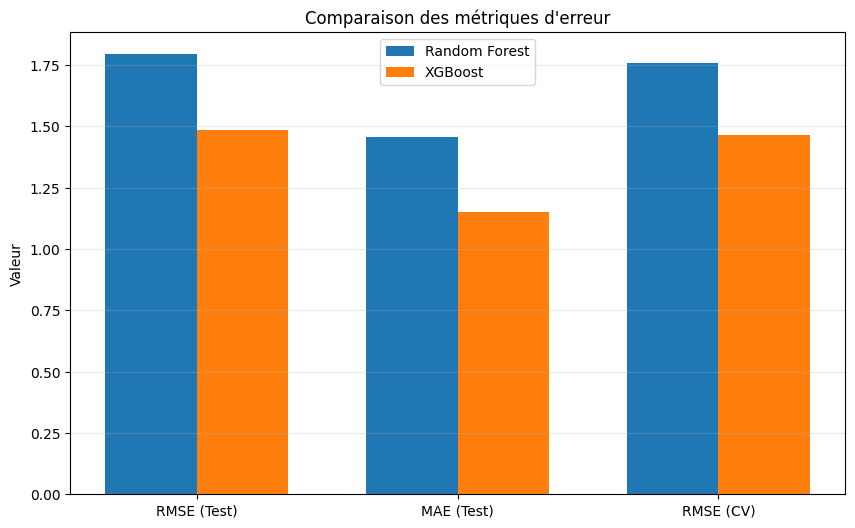

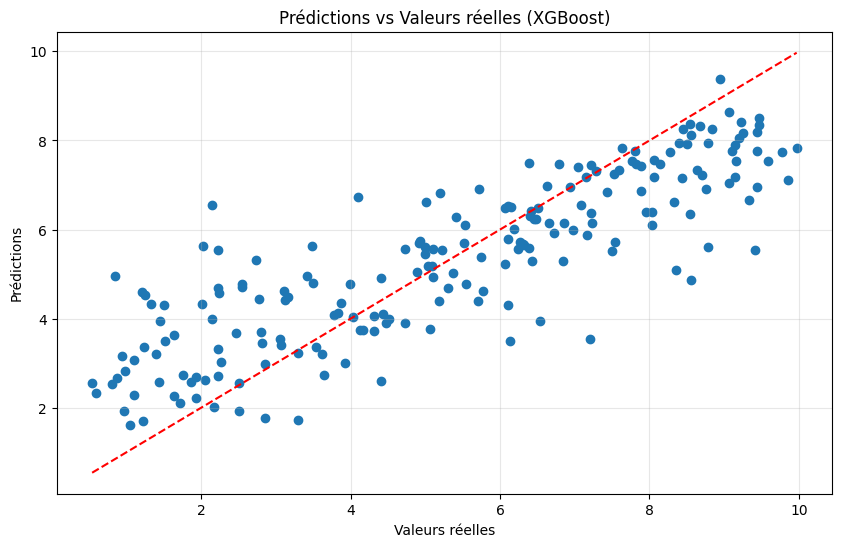

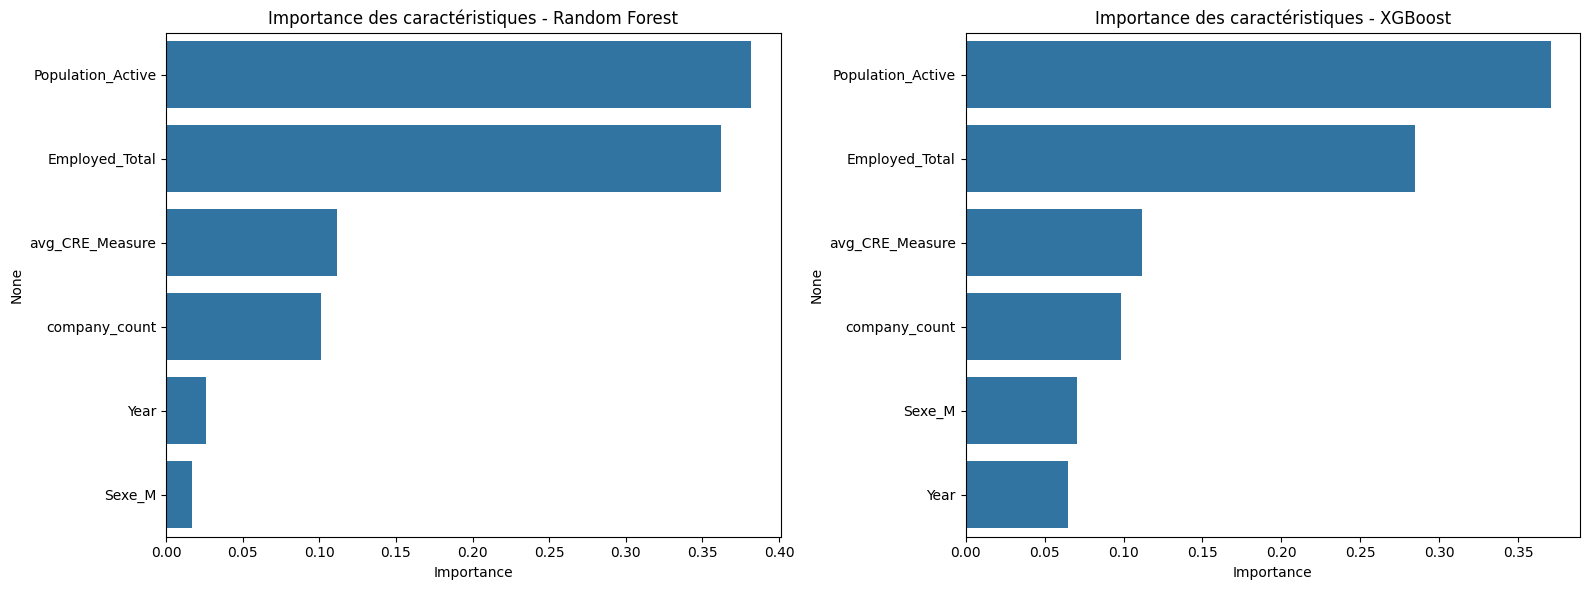


Conclusion:
XGBoost est le meilleur modèle avec un R² de 0.6945 contre 0.5545 pour Random Forest

Meilleurs hyperparamètres pour XGBoost:
learning_rate: 0.1
max_depth: 5
n_estimators: 300
subsample: 0.8


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('merged_data.csv') 

# Conversion de TIME_PERIOD en caractéristiques temporelles
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y')
df['Year'] = df['TIME_PERIOD'].dt.year
df['Month'] = df['TIME_PERIOD'].dt.month if 'Month' in str(df['TIME_PERIOD'][0]) else 1

# Encodage des variables catégorielles
encoder = OneHotEncoder(sparse_output=False, drop='first')
sexe_encoded = encoder.fit_transform(df[['Sexe']])
sexe_df = pd.DataFrame(sexe_encoded, columns=encoder.get_feature_names_out(['Sexe']))

# Fusion des données encodées
df = pd.concat([df, sexe_df], axis=1)

X = df[['Year', 'Employed_Total', 'Population_Active', 'company_count', 'avg_CRE_Measure', 'Sexe_M']]
y = df['Taux_Chomage (%)']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ****** Modèle Random Forest*******
rf_model = RandomForestRegressor(random_state=42)

# Hyperparamètres à tester pour Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Recherche par grille pour Random Forest
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# ****** Modèle XGBoost******
xgb_model = xgb.XGBRegressor(random_state=42)

# Hyperparamètres à tester pour XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

# Recherche par grille pour XGBoost
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

# ****** Évaluation des modèles*******
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métriques d'erreur
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Validation croisée
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Affichage des résultats
    print(f"\n{model_name} - Résultats:")
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"CV RMSE: {cv_rmse:.4f}")
    
    return {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'y_test': y_test,
        'y_pred': y_test_pred
    }

# Évaluation des deux modèles
rf_results = evaluate_model(rf_best, X_train, y_train, X_test, y_test, "Random Forest")
xgb_results = evaluate_model(xgb_best, X_train, y_train, X_test, y_test, "XGBoost")

# Visualisation comparative des résultats
def plot_results(rf_results, xgb_results):
    # Comparaison des métriques
    metrics = ['test_rmse', 'test_mae', 'cv_rmse']
    rf_values = [rf_results[m] for m in metrics]
    xgb_values = [xgb_results[m] for m in metrics]
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, rf_values, width, label='Random Forest')
    plt.bar(x + width/2, xgb_values, width, label='XGBoost')
    
    plt.xticks(x, ['RMSE (Test)', 'MAE (Test)', 'RMSE (CV)'])
    plt.ylabel('Valeur')
    plt.title('Comparaison des métriques d\'erreur')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Prédictions vs valeurs réelles pour le meilleur modèle
    best_model = "Random Forest" if rf_results['test_r2'] > xgb_results['test_r2'] else "XGBoost"
    best_results = rf_results if best_model == "Random Forest" else xgb_results
    
    plt.figure(figsize=(10, 6))
    plt.scatter(best_results['y_test'], best_results['y_pred'])
    plt.plot([min(best_results['y_test']), max(best_results['y_test'])], 
             [min(best_results['y_test']), max(best_results['y_test'])], 'r--')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    plt.title(f'Prédictions vs Valeurs réelles ({best_model})')
    plt.grid(True, alpha=0.3)
    plt.show()

# Affichage graphique des résultats
plot_results(rf_results, xgb_results)

# Importance des caractéristiques
def plot_feature_importance(rf_model, xgb_model, feature_names):
    # Importance des caractéristiques pour Random Forest
    rf_importances = pd.Series(rf_model.feature_importances_, index=feature_names)
    rf_importances = rf_importances.sort_values(ascending=False)
    
    # Importance des caractéristiques pour XGBoost
    xgb_importances = pd.Series(xgb_model.feature_importances_, index=feature_names)
    xgb_importances = xgb_importances.sort_values(ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Random Forest
    sns.barplot(x=rf_importances.values, y=rf_importances.index, ax=ax1)
    ax1.set_title('Importance des caractéristiques - Random Forest')
    ax1.set_xlabel('Importance')
    
    # XGBoost
    sns.barplot(x=xgb_importances.values, y=xgb_importances.index, ax=ax2)
    ax2.set_title('Importance des caractéristiques - XGBoost')
    ax2.set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()

# Affichage de l'importance des caractéristiques
plot_feature_importance(rf_best, xgb_best, X.columns)

# Conclusion
print("\nConclusion:")
if rf_results['test_r2'] > xgb_results['test_r2']:
    print(f"Random Forest est le meilleur modèle avec un R² de {rf_results['test_r2']:.4f} contre {xgb_results['test_r2']:.4f} pour XGBoost")
    best_model = rf_best
    best_model_name = "Random Forest"
else:
    print(f"XGBoost est le meilleur modèle avec un R² de {xgb_results['test_r2']:.4f} contre {rf_results['test_r2']:.4f} pour Random Forest")
    best_model = xgb_best
    best_model_name = "XGBoost"

# Affichage des meilleurs hyperparamètres
print(f"\nMeilleurs hyperparamètres pour {best_model_name}:")
if best_model_name == "Random Forest":
    params = rf_grid.best_params_
else:
    params = xgb_grid.best_params_
for param, value in params.items():
    print(f"{param}: {value}")

Entraînement du modèle XGBoost final...

Résultats du modèle XGBoost final:
Train RMSE: 0.2059, Test RMSE: 1.4846
Train MAE: 0.1568, Test MAE: 1.1504
Train R²: 0.9941, Test R²: 0.6945

Importance des caractéristiques:
             Feature  Importance
2  Population_Active    0.370483
1     Employed_Total    0.284308
4    avg_CRE_Measure    0.111500
3      company_count    0.098274
5             Sexe_M    0.070756
0               Year    0.064679


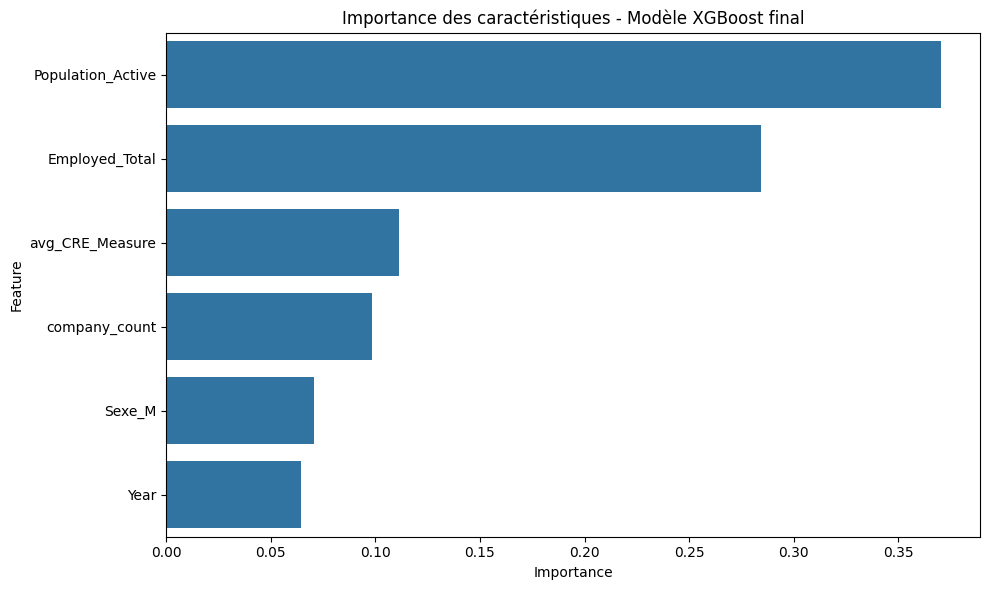

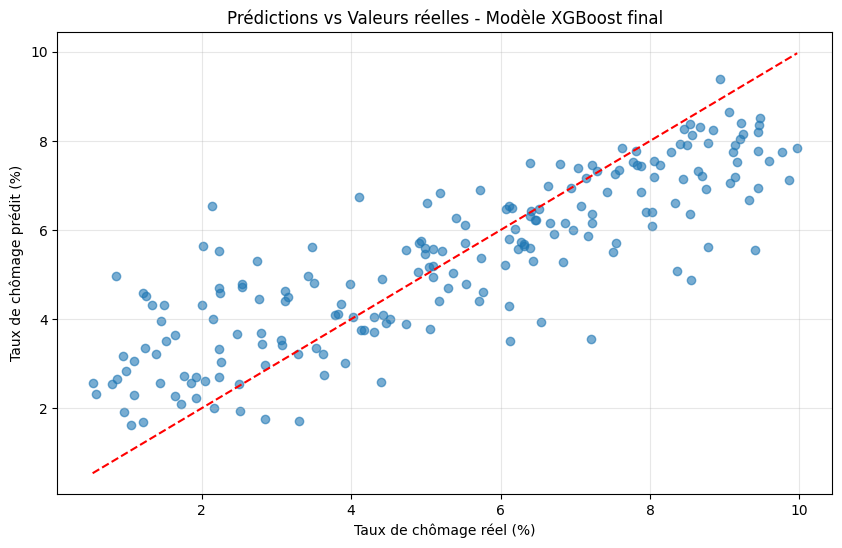


Exemple de prédiction:
Taux de chômage prédit pour 2023: 8.55%

Sauvegarde du modèle...
Modèle sauvegardé avec succès sous 'model_xgboost.pkl'
Informations sur les caractéristiques sauvegardées avec succès


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('merged_data.csv')

df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y')
df['Year'] = df['TIME_PERIOD'].dt.year
df['Month'] = df['TIME_PERIOD'].dt.month if 'Month' in str(df['TIME_PERIOD'][0]) else 1

# Encodage des variables catégorielles
try:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
except TypeError:
    encoder = OneHotEncoder(sparse=False, drop='first')

sexe_encoded = encoder.fit_transform(df[['Sexe']])
sexe_df = pd.DataFrame(sexe_encoded, columns=encoder.get_feature_names_out(['Sexe']))

# Fusion des données encodées
df = pd.concat([df, sexe_df], axis=1)

X = df[['Year', 'Employed_Total', 'Population_Active', 'company_count', 'avg_CRE_Measure', 'Sexe_M']]
y = df['Taux_Chomage (%)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle XGBoost final avec les meilleurs hyperparamètres
print("Entraînement du modèle XGBoost final...")
final_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=300,
    subsample=0.8,
    random_state=42
)

final_model.fit(X_train, y_train)

# Évaluation du modèle final
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Métriques de performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nRésultats du modèle XGBoost final:")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

# Analyse des coefficients d'importance
importance = final_model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nImportance des caractéristiques:")
print(feat_importance)

# Visualisation de l'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title('Importance des caractéristiques - Modèle XGBoost final')
plt.tight_layout()
plt.show()

# Visualisation Prédictions vs Valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Taux de chômage réel (%)')
plt.ylabel('Taux de chômage prédit (%)')
plt.title('Prédictions vs Valeurs réelles - Modèle XGBoost final')
plt.grid(True, alpha=0.3)
plt.show()

# Fonction pour faire des prédictions futures
def predict_unemployment_rate(model, year, employed_total, population_active, 
                             company_count, avg_cre_measure, sexe_m):
    """
    Prédire le taux de chômage avec le modèle entraîné
    
    Parameters:
    -----------
    model : modèle XGBoost entraîné
    year : année (int)
    employed_total : nombre total d'employés (float)
    population_active : population active (float)
    company_count : nombre d'entreprises (int)
    avg_cre_measure : mesure CRE moyenne (float)
    sexe_m : 1 pour Homme, 0 pour Femme (int)
    
    Returns:
    --------
    float : Taux de chômage prédit
    """
    data = np.array([[year, employed_total, population_active, 
                    company_count, avg_cre_measure, sexe_m]])
    
    # Créer un DataFrame avec les noms de colonnes appropriés
    prediction_df = pd.DataFrame(data, columns=X.columns)
    
    # Prédire
    prediction = model.predict(prediction_df)[0]
    
    return prediction

# Exemple de prédiction
print("\nExemple de prédiction:")
prediction = predict_unemployment_rate(
    final_model, 
    2023,                    # Année
    55000,                   # Employed_Total
    60000,                   # Population_Active 
    1200,                    # company_count
    50,                      # avg_CRE_Measure
    1                        # Sexe_M (1 pour homme)
)
print(f"Taux de chômage prédit pour 2023: {prediction:.2f}%")

# Sauvegarder le modèle pour utilisation future avec Streamlit
print("\nSauvegarde du modèle...")
with open('model_xgboost.pkl', 'wb') as file:
    pickle.dump(final_model, file)

print("Modèle sauvegardé avec succès sous 'model_xgboost.pkl'")

# Sauvegarder également la structure des données d'entrée pour faciliter l'utilisation
feature_info = {
    'column_names': list(X.columns),
    'feature_importance': {name: float(importance) for name, importance in zip(X.columns, final_model.feature_importances_)}
}

with open('feature_info_ancrage_territorial.pkl', 'wb') as file:
    pickle.dump(feature_info, file)

print("Informations sur les caractéristiques sauvegardées avec succès")

Features utilisées : ['YearIndex', 'Sexe_M', 'age_15-24', 'age_25-39', 'age_40-54', 'age_55-64', 'log_Employed_Total', 'log_Population_Active', 'log_company_count', 'avg_CRE_Measure']
   YearIndex  Sexe_M  age_15-24  age_25-39  age_40-54  age_55-64  \
0          0       0       True      False      False      False   
1          0       0       True      False      False      False   
2          0       0       True      False      False      False   
3          0       0       True      False      False      False   
4          0       0       True      False      False      False   

   log_Employed_Total  log_Population_Active  log_company_count  \
0           10.639955              10.690749           7.130099   
1           10.783263              10.841566           7.090910   
2           11.112913              11.141937           7.094235   
3           10.983551              11.027937           7.100027   
4           10.920689              11.009796           7.107425   

   a

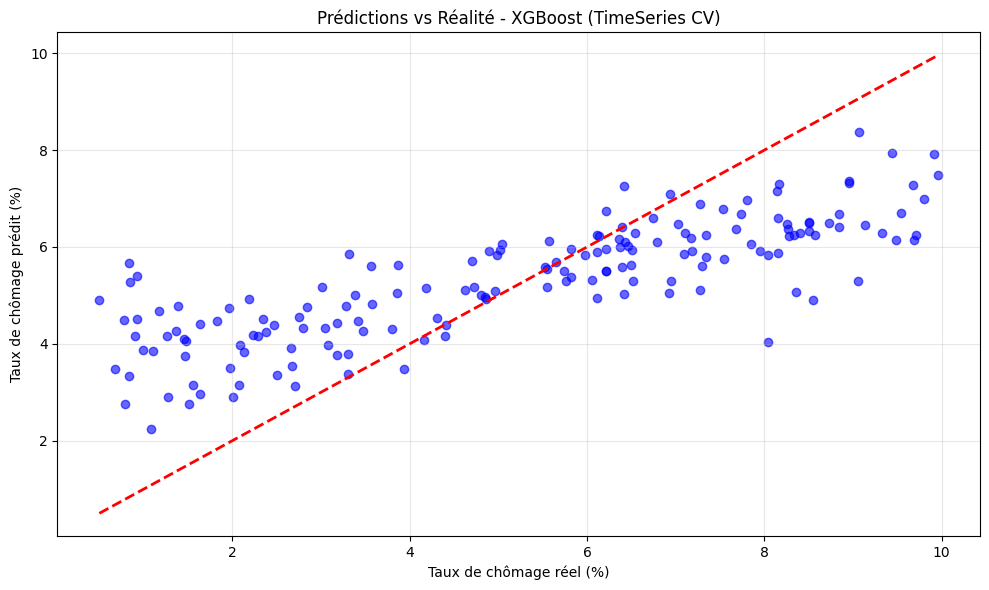


Modèle sauvegardé sous 'xgboost_model_future.pkl'
Informations sur les features sauvegardées dans 'feature_info_future.pkl'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import pickle

# =====================================================
# 1. Chargement et Prétraitement des Données
# =====================================================

# Charger le fichier CSV
df = pd.read_csv('merged_data.csv')

# On suppose que TIME_PERIOD contient l'année (ex: 2017, 2018, …)
df['Year'] = df['TIME_PERIOD']

# Création d'une variable numérique pour la dimension temporelle : YearIndex
df['YearIndex'] = df['TIME_PERIOD'] - df['TIME_PERIOD'].min()
# Par exemple, si TIME_PERIOD commence en 2017, alors 2017 -> 0, 2018 -> 1, etc.

# =====================================================
# 2. Encodage des Variables Catégorielles
# =====================================================

# Encodage binaire du Sexe : "M" -> 1, "F" -> 0
df['Sexe_M'] = np.where(df['Sexe'] == 'M', 1, 0)

# Encodage des tranches d'âge en one-hot (ex: "15-24", "25-39", "40-54", "55-64")
age_dummies = pd.get_dummies(df['age'], prefix='age')
df = pd.concat([df, age_dummies], axis=1)

# =====================================================
# 3. Transformation des Variables Numériques
# =====================================================

# Pour éviter la fuite d’information, on retire Unemployed_Total.
# On conserve Population_Active et Employed_Total.
df['log_Employed_Total']    = np.log1p(df['Employed_Total'])
df['log_Population_Active'] = np.log1p(df['Population_Active'])
df['log_company_count']     = np.log1p(df['company_count'])
# avg_CRE_Measure est utilisé tel quel.

# =====================================================
# 4. Sélection des Features et de la Cible
# =====================================================

# On utilise uniquement des features qui devraient être disponibles au moment de la prévision.
# On exclut Unemployed_Total (source de fuite).
features = [
    'YearIndex',        # Dimension temporelle
    'Sexe_M',           # Sexe encodé
    'age_15-24', 'age_25-39', 'age_40-54', 'age_55-64',  # One-hot encoding de l'âge
    'log_Employed_Total',
    'log_Population_Active',
    'log_company_count',
    'avg_CRE_Measure'
]
target = 'Taux_Chomage (%)'

X = df[features]
y = df[target]

print("Features utilisées :", X.columns.tolist())
print(X.head())

# =====================================================
# 5. Split Chronologique : Train (années antérieures à 2022) / Test (2022)
# =====================================================

# Séparation temporelle pour simuler une vraie prévision future.
train_df = df[df['Year'] < 2022]
test_df  = df[df['Year'] == 2022]

X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]

print(f"\nTaille du train : {X_train.shape}, Taille du test : {X_test.shape}")

# =====================================================
# 6. Optimisation des Hyperparamètres avec TimeSeriesSplit
# =====================================================

# Création de TimeSeriesSplit pour respecter l'ordre temporel
tscv = TimeSeriesSplit(n_splits=3)

# Création du modèle XGBoost compatible scikit-learn
xgb_model = XGBRegressor(
    n_estimators=1000,   # Nombre maximum d'arbres (early stopping limitera le nombre effectif)
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Définition des plages pour les hyperparamètres
param_distributions = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

# Entraînement de la recherche sur le jeu d'entraînement complet
random_search.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres :", random_search.best_params_)
print("Meilleur score (MSE négatif moyen) :", random_search.best_score_)

# Sélection du meilleur modèle
best_model = random_search.best_estimator_

# =====================================================
# 7. Évaluation du Modèle sur le Jeu de Test
# =====================================================

y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
print("\nPerformance sur le jeu de test :")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test R² : {test_r2:.4f}")

# =====================================================
# 8. Visualisation : Prédictions vs Réalité (2022)
# =====================================================

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Taux de chômage réel (%)')
plt.ylabel('Taux de chômage prédit (%)')
plt.title('Prédictions vs Réalité - XGBoost (TimeSeries CV)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================================
# 9. Sauvegarde du Modèle et des Informations sur les Features
# =====================================================

# Sauvegarde du modèle au format pickle
with open('xgboost_model_future.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("\nModèle sauvegardé sous 'xgboost_model_future.pkl'")

# Sauvegarde de la liste des features utilisées
feature_info = {'features': features}
with open('feature_info_future.pkl', 'wb') as f:
    pickle.dump(feature_info, f)
print("Informations sur les features sauvegardées dans 'feature_info_future.pkl'") 
